## Tópicos Especiais em Inteligência Artificial

## Classificação de diagnóstico de câncaer de mama com Deep Neural Network (DNN)

Neste trabalho vamos utilizar o dataset Breast Cancer Wisconsin (Diagnostic) disponível no repositório de datasets da UCI. Este é um conjunto de dados multivariado com atributos numéricos de ponto flutuante usado para classificação do tipo de câncer de mama de um paciente com: MALIGNO ou BENIGNO. O dataset mostra resultados de exames de 699 pacientes coletados entre 1989 e 1991. É composto de 11 atributos que são usados como entrada no modelo:

1. ID do paciente
2. Espessura (1-10)
3. Uniformidade de tamanho da célula (1-10)
4. Uniformidade de forma da célula (1-10)
5. Adeesão marginal (1-10)
6. Tamanho único epitelial da célula (1-10)
7. Quantidade de núcleos nus (1-10)
8. Cromatina (1-10)
9. Quantidade de núcleos normais (1-10)
10. Mitoses (1-10)  
11. [SAÍDA] Classificação (2 para indicar BENIGNO, 4 para indicar MALIGNO)

O dataset contém 458 amostras com:
- 65.5% de casos BENIGNOS
- 34.5% de casos MALIGNOS

## 1. Preparação do ambiente

In [1]:
#funcao para deixar o jupyter com celulas preenchendo a tela toda
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#importacao de bibliotecas

#para exportar o requiriments
import subprocess
import sys

#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split #divisao dos conjuntos
from sklearn.metrics import confusion_matrix

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load #gera, exporta e usa (salva no HD)

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para deep learning
import tensorflow.keras 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LayerNormalization, BatchNormalization, Flatten, Dense, Reshape, Dropout

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryCrossentropy

#bibliotecas para plotar graficos do keras
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
/home/victor/anaconda3/envs/dl_tf/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.32.54, Python 3.11.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


2025-11-19 13:17:48.231662: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 13:17:48.348493: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-19 13:17:48.348513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-19 13:17:48.371394: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-19 13:17:48.408453: I tensorflow/core/platform/cpu_feature_guar

In [3]:
import tensorflow as tf
import keras
print("Versão do Keras: ", keras.__version__)
print("Versão do TensorFlow:", tf.__version__)
print("GPUs disponíveis:", len(tf.config.list_physical_devices('GPU')) > 0)
print("GPU: ", tf.config.list_physical_devices('GPU'))

Versão do Keras:  2.15.0
Versão do TensorFlow: 2.15.0
GPUs disponíveis: True
GPU:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-11-19 13:17:51.041811: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-19 13:17:51.261379: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-19 13:17:51.261628: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
#rotina para exportação da lista de pacotes
def exportaRequirements():
    try:
        resultado = subprocess.run([sys.executable, '-m', 'pip', 'freeze'], #executando uma consulta a todas as bib do ambiente e guradando
                                capture_output = True, #dentro de resultado
                                text = True,
                                check = True)
        
        with open('requirements.txt', 'w') as f:
            f.write(resultado.stdout) #escrevendo as bib dentro desse arquivo

        print('Arquivo exportado com sucesso!')
    except subprocess.CalledProcessError as e:
        print(f"Deu erro:{e}")

exportaRequirements()


Arquivo exportado com sucesso!


## 2. Importação do dataset

In [5]:
#2 BENIGNO --- 4 MALIGNO
#cria um nome para cada coluna no dataset
col_names = ['ID', 'espessura', 'tam_celula' , 'forma_celula', 'adesao', 'tam_epitelial', 'nucleos_nus', 'cromatina'
            , 'nucleos_normais', 'mitoses', 'diagnostico']

#importacao do dataset
data = pd.read_csv('dataset/breast-cancer-wisconsin.csv', header=None, names=col_names)

#remove a coluna ID, pq ela nao sera usada para nada
data = data.drop('ID', axis=1) #axis 0 ou 1, 0 tira linha e 1 tira coluna

#substitui um campo '?' por NaN
data = data.replace('?', np.NaN)

#converte tudo para numero
data = data.astype(float)

#converte o codigo do diagnostico
data = data.assign(diagnostico=data['diagnostico'].replace({2: 0, 4:1})) #a coluna diagnostico onde tem 2 passa a ser 0 e 4 vira 1

#nomeia as entradas e saidas
x_names = data.columns[:-1].tolist() #pega todas as colunas (:) menos a última (-1)
y_names = data.columns[-1:].tolist() #pega a última coluna


In [6]:
data

,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nucleos_normais,mitoses,diagnostico
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
694,3.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,0.0
695,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0
696,5.0,10.0,10.0,3.0,7.0,3.0,8.0,10.0,2.0,1.0
697,4.0,8.0,6.0,4.0,3.0,4.0,10.0,6.0,1.0,1.0


## 3. Configuração do Experimento

In [7]:
#realizar interpolacao de dados (criacao de dados sinteticos - nesse caso vizinho mais proximo)
interp_exec = True

#realizar deteccao e substituicao de outliers
outliers_exec = True

#realizar normalizacao de dados
normalization_exec = True

#realizar escalonamento de dados
scale_exec = True

#exportar os datasets tratados
export_frames = True

#gerar um novo modelo ou usar um pronto
new_model = True

## 4. Análise de Dados

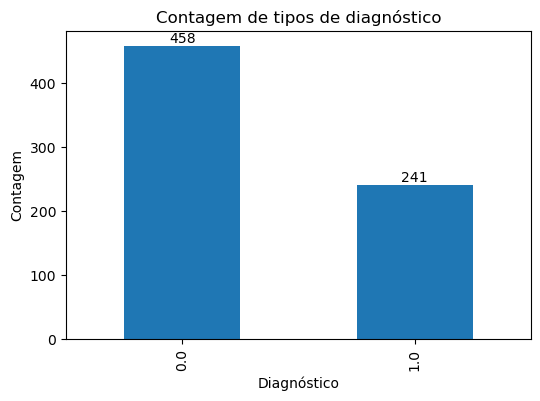

In [8]:
#contagem de diagnosticos
diag_counts = data['diagnostico'].value_counts()

#plota grafico de barra
plt.figure(figsize=(6,4))
diag_counts.plot(kind='bar')
plt.xlabel('Diagnóstico')
plt.ylabel('Contagem')
plt.title('Contagem de tipos de diagnóstico')

#adiciona os rotulos
for i, count in enumerate(diag_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

### 4.1 Sumarização estatística

In [9]:
def sumarizacao(data):
    stats = []

    for column in x_names:
        values = data[column]

        maximum = round(values.max(), 2) #arredonda o valor maximo da coluna no momento com duas casas decimais
        minimum = round(values.min(), 2)
        mean = round(values.mean(), 2)
        median = round(values.median(), 2)
        std = round(values.std(), 2)
        stats.append([column, maximum, minimum, mean, median, std])

    headers = ['Coluna', 'Máximo', 'Mínimo', 'Média', 'Mediana', 'Desvio Padrão']

    table = tabulate(stats, headers, tablefmt='pipe')
    print(table)

sumarizacao(data)

| Coluna          |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:----------------|---------:|---------:|--------:|----------:|----------------:|
| espessura       |       10 |        1 |    4.42 |         4 |            2.82 |
| tam_celula      |       10 |        1 |    3.13 |         1 |            3.05 |
| forma_celula    |       10 |        1 |    3.21 |         1 |            2.97 |
| adesao          |       10 |        1 |    2.81 |         1 |            2.86 |
| tam_epitelial   |       10 |        1 |    3.22 |         2 |            2.21 |
| nucleos_nus     |       10 |        1 |    3.54 |         1 |            3.64 |
| cromatina       |       10 |        1 |    3.44 |         3 |            2.44 |
| nucleos_normais |       10 |        1 |    2.87 |         1 |            3.05 |
| mitoses         |       10 |        1 |    1.59 |         1 |            1.72 |


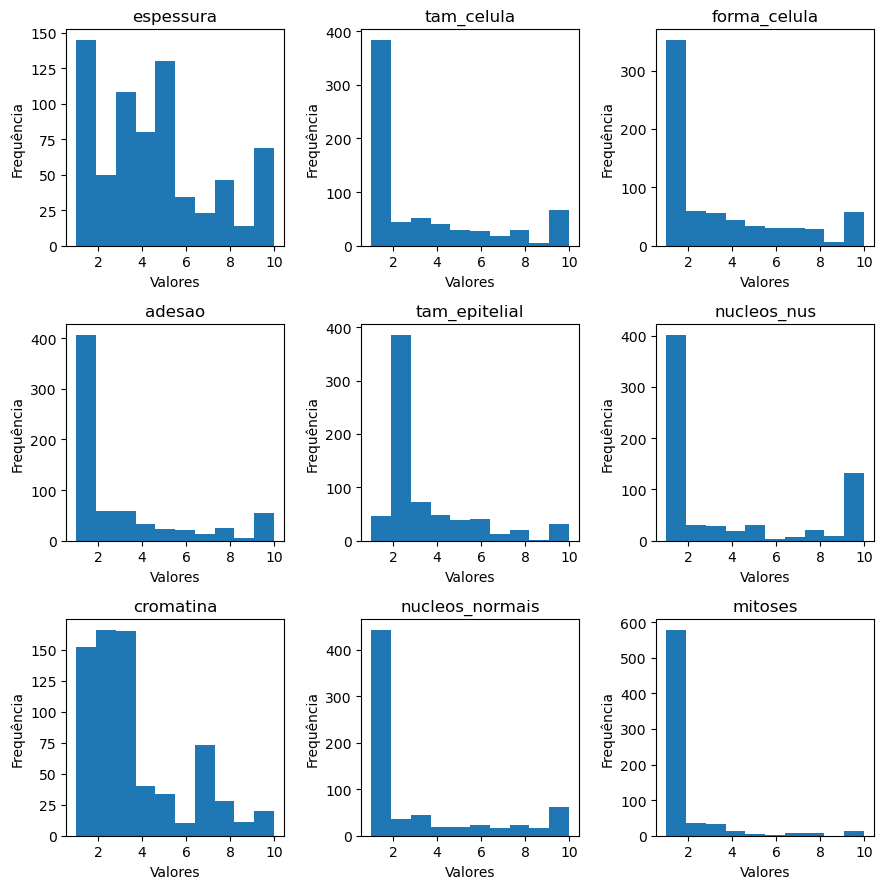

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9), tight_layout=True)

#pltar o grafico para cada coluna de entrada
for i, column in enumerate(x_names):
    row = i // 3 #linha atual
    col = i % 3 #coluna atual
    axs[row, col].hist(data[column], bins=10) #bins -> tamanho da classe do histograma
    axs[row, col].set_title(column)
    axs[row, col].set_xlabel('Valores')
    axs[row, col].set_ylabel('Frequência')

plt.show()

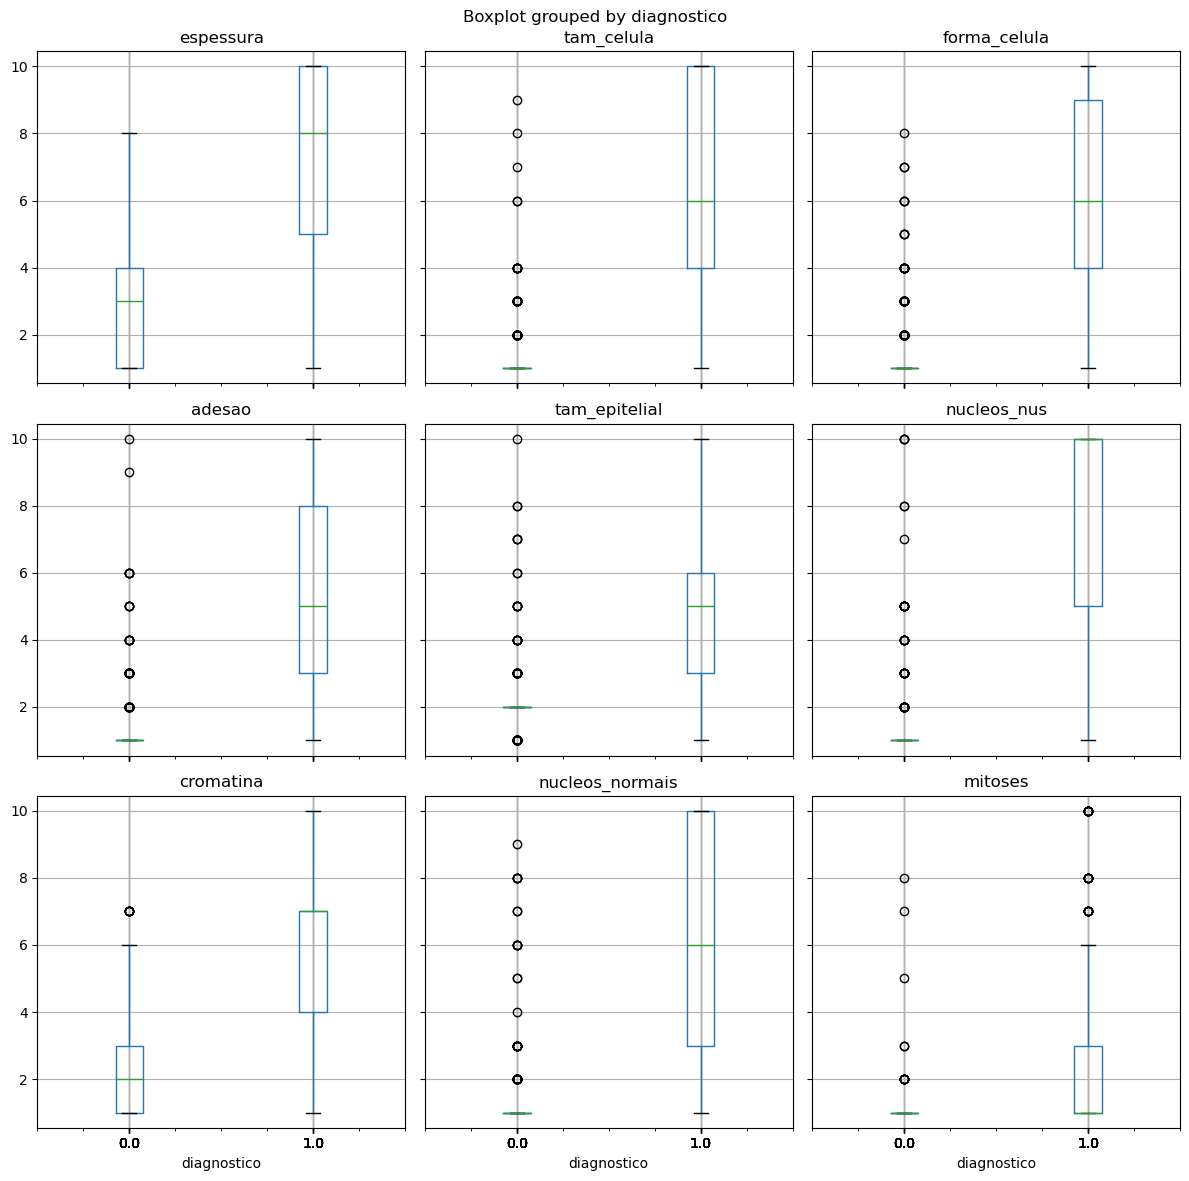

In [11]:
#boxplot para ver se tem outliers (IQR)
data.boxplot(column=x_names, by='diagnostico', figsize=(12, 12)) #by = separar por diagnostico
plt.tight_layout()
plt.show()

### 4.2 Deteccção de dados faltantes e interpolação

In [12]:
missing_counts = data.isnull().sum()
print("Total de dados faltantes por atributo (coluna):\n", missing_counts)

Total de dados faltantes por atributo (coluna):
 espessura           0
tam_celula          0
forma_celula        0
adesao              0
tam_epitelial       0
nucleos_nus        16
cromatina           0
nucleos_normais     0
mitoses             0
diagnostico         0
dtype: int64


In [13]:
#interpola os dados faltantes (vizinho mais proximo)
def interpolacao(data):
    if data.isnull().values.any(): #se existir pelo menos um dado faltante
        points_inds_danger = [0, 1, len(data) - 2, len(data) - 1] #tem que existr pelo menos o 1º, 2º, penultimo e ultimo dado para interpolar

        #esse for garante que vai ter numeros nos indices do vetor a cima
        for colname in x_names:
            for ind_danger in points_inds_danger:
                if np.isnan(data[colname].iloc[ind_danger].astype(float)): #converte para float e compara com NaN, se for, entra if
                    data[colname].iloc[ind_danger] = data[colname].mean()
            
            data[colname] = data[colname].interpolate(method='nearest').copy()
    
    return data
            


In [14]:
if interp_exec:
    data = interpolacao(data)

In [15]:
missing_counts = data.isnull().sum()
print("Total de dados faltantes por atributo (coluna):\n", missing_counts)

Total de dados faltantes por atributo (coluna):
 espessura          0
tam_celula         0
forma_celula       0
adesao             0
tam_epitelial      0
nucleos_nus        0
cromatina          0
nucleos_normais    0
mitoses            0
diagnostico        0
dtype: int64


### 4.3 Detecção e substituição de outliers

In [16]:
def getQuantiles(x, margin = 1.5, low = 0.1, high = 0.9):
    
    q1 = x.quantile(low)
    q3 = x.quantile(high)
    iqr = q3 - q1
    fence_low = q1 - (margin * iqr)
    fence_high = q3 + (margin * iqr)

    return [fence_low, fence_high]

def replaceOutliers(serie, m):

    x = serie.copy()

    fences = getQuantiles(x, margin = m)
    bad_inds = x.loc[(x < fences[0]) | (x > fences[1])].index
    x[bad_inds] = np.nan

    outlier_inds_danger = [0, 1, len(serie) - 2, len(serie) - 1]
    for ind_danger in outlier_inds_danger:
        if np.isnan(x.iloc[ind_danger]):
            x[ind_danger] = (fences[0] + fences[1]) / 2 #media dos dois limites


    if x.isnull().values.any(): #se tiver pelo menos um nulo
        x = x.interpolate(method="nearest").copy()
    
    return x


In [17]:
if outliers_exec:
    for col in x_names:
        data[col] = replaceOutliers(data[col], 0)

### 4.4 Aplicando normalização (estabilização de variância)

In [18]:
def normalization(data, method):
    if method == 'asinh':
        return np.arcsinh(data)
    elif method == 'log':
        return np.log(data)
    else:
        return (data - np.mean(data)) / np.std(data)

In [19]:
if normalization_exec:
    for col in x_names:
        data[col] = normalization(data[col], 'mean') 

In [20]:
data

,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nucleos_normais,mitoses,diagnostico
0,0.481973,-0.653930,-0.706788,-0.582619,-0.620341,-0.696275,0.026555,-0.544156,-0.331584,0.0
1,0.481973,0.728420,0.683582,1.497845,0.953592,1.781250,0.026555,-0.089717,-0.331584,0.0
2,-0.386324,-0.653930,-0.706788,-0.582619,-0.620341,-0.420994,0.026555,-0.544156,-0.331584,0.0
3,0.916122,2.571552,2.537408,-0.582619,0.166625,0.129567,0.026555,2.182474,-0.331584,0.0
4,0.047825,-0.653930,-0.706788,0.457613,-0.620341,-0.696275,0.026555,-0.544156,-0.331584,0.0
...,...,...,...,...,...,...,...,...,...,...
694,-0.386324,-0.653930,-0.706788,-0.582619,0.166625,-0.420994,-1.034124,-0.544156,-0.331584,0.0
695,-0.820473,-0.653930,-0.706788,-0.582619,-0.620341,-0.696275,-1.034124,-0.544156,-0.331584,0.0
696,0.481973,-0.653930,-0.706788,0.457613,-0.620341,-0.145714,-1.034124,-0.544156,1.683871,1.0
697,0.047825,2.571552,1.610495,0.977729,0.166625,0.129567,0.556894,1.728036,-0.331584,1.0


### 4.5 Aplicando escalonamento nos dados

In [21]:
#funcao que cria uma regua com valores minimos e maximos para se usar no escalonamento
def create_support_col(minvalue, maxvalue, sizecol):
    minvalues = [minvalue] * round(sizecol/2)
    maxvalues = [maxvalue] * (sizecol - round(sizecol/2))

    return [*minvalues, *maxvalues]

def minMaxIndividual(df, col, minvalue, maxvalue, rgint):
    serie = df[col].copy()
    
    #cria uma regua com um valor minimo e maximo prviamente determinado
    serie['support'] = create_support_col(minvalue, maxvalue, len(serie))

    #escalona considerando o minimo e o maximo especificado
    tmp = serie.to_numpy().reshape(-1, 1) #nao tem linha e tem 1 coluna

    #cria o objeto de escalonamento
    minMaxScaler = preprocessing.MinMaxScaler(feature_range = rgint).fit(tmp) #vai ajustar o vetor dentro do intervalo

    #cria os dados escalonados
    scaled = minMaxScaler.transform(tmp).reshape(serie.shape[0], serie.shape[1])

    #remove a coluna de suporte e atualiza as colunas escalonadas no dataset
    df[col] = scaled[:, 0:(scaled.shape[1]-1)]

    return df

In [22]:
scale_range = (0, 1)

if scale_exec:
    for col in x_names:
        data = minMaxIndividual(data, [col], np.min(data[col]), np.max(data[col]), scale_range)

In [ ]:
sumarizacao(data)

| Coluna          |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:----------------|---------:|---------:|--------:|----------:|----------------:|
| espessura       |        1 |        0 |    0.36 |      0.38 |            0.29 |
| tam_celula      |        1 |        0 |    0.18 |      0    |            0.27 |
| forma_celula    |        1 |        0 |    0.22 |      0    |            0.31 |
| adesao          |        1 |        0 |    0.16 |      0    |            0.27 |
| tam_epitelial   |        1 |        0 |    0.2  |      0    |            0.32 |
| nucleos_nus     |        1 |        0 |    0.28 |      0    |            0.4  |
| cromatina       |        1 |        0 |    0.32 |      0.33 |            0.31 |
| nucleos_normais |        1 |        0 |    0.15 |      0    |            0.28 |
| mitoses         |        1 |        0 |    0.08 |      0    |            0.25 |


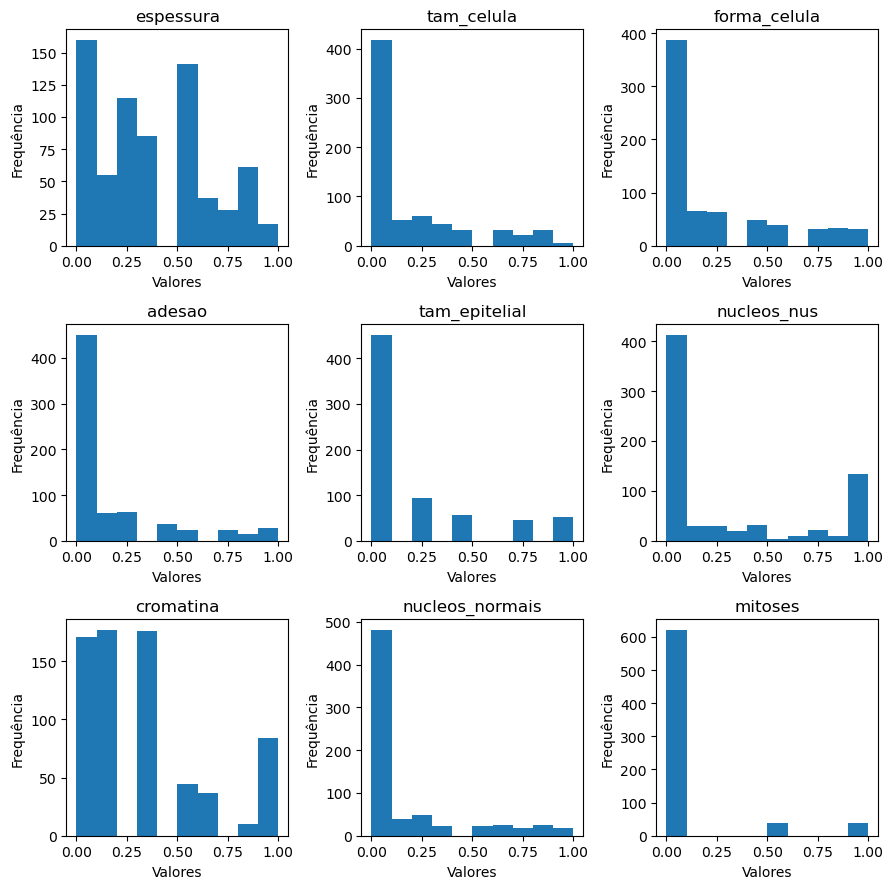

In [27]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9), tight_layout=True)

#pltar o grafico para cada coluna de entrada
for i, column in enumerate(x_names):
    row = i // 3 #linha atual
    col = i % 3 #coluna atual
    axs[row, col].hist(data[column], bins=10) #bins -> tamanho da classe do histograma
    axs[row, col].set_title(column)
    axs[row, col].set_xlabel('Valores')
    axs[row, col].set_ylabel('Frequência')

plt.show()

### 4.6 Exportando ou carregando um dataset tratado

In [24]:
if export_frames:
    bar = progressbar.ProgressBar(maxval = len(data), widgets=[progressbar.Bar("=", "[", "]"), " ", progressbar.Percentage()])
    bar.start()

    x_frames = []
    y_frames = []

    cont = 0
    for ind in range(0, len(data), 1):
        x_frames.append(data.loc[ind, x_names].values) #pegando a linha ind e somente as colunas de entrada
        y_frames.append(data.loc[ind, y_names].values.reshape(-1))

        bar.update(cont + 1)
        cont += 1
    
    x_frames = np.array(x_frames)
    y_frames = np.array(y_frames).reshape(-1, 1)

    dump(x_frames, 'dataset/x_frames.joblib')
    dump(y_frames, 'dataset/y_frames.joblib')

    bar.finish()

else:
    x_frames = load('dataset/x_frames.joblib')
    y_frames = load('dataset/y_frames.joblib')

print(x_frames.shape)
print(y_frames.shape)

(699, 9)
(699, 1)


In [26]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x_frames, y_frames, test_size = 0.3, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = 0.2, shuffle=True)

print("Treino: ")
print(x_train.shape)
print(y_train.shape)

print("Validação:")
print(x_val.shape)
print(y_val.shape)

print("Teste:")
print(x_test.shape)
print(y_test.shape)

Treino: 
(391, 9)
(391, 1)
Validação:
(98, 9)
(98, 1)
Teste:
(210, 9)
(210, 1)
